# NOTES

## REMINDER: splitting on periods isn't enough. What about question marks?

### considerations:

1. Mining reflections
  - The answer text is not equivalent to a reflection. Need to extract reflections from the answer text. As hinted in the challenge...
    - First sentence is often a good reflection
    - Sentences that start with "Sounds like" and "Seems like" are have potential to be good reflections
1. Transfer learning
  - Easy to leverage transfer learning with transformers through the HuggingFace library
  - More difficult to do so with LSTMs.
    - Could download a pretrained LSTM language model
    - Could initialize word embeddings with GloVe
    - Could intialize LSTM decoder word embeddings by cloning roBERTa embeddings

### potential solutions:

1. Generative model, essentially a neural machine translation (NMT) system
  - Would be ideal to start with a pretrained language model (eg, GPT) and fine tune it to this NMT task
1. Train a multiclass classifier to predict the reflection given the question text.
  - Reflection diversity/variablility/sparsity
    - Due to minor text variations, would need to cluster the mined reflections into distinct entities.
    - The actual set of reflection entities could be very sparse (ie, very few examples per reflection). This would pose learning problems.

### generative model

Possible designs for a generative model:

1. Ideal model: a seq2seq roBERTa encoder + roBERTa decoder, each initialized from LM pretraining. The challenge is in developing the training routine, which would require a left-to-right attention mask in the decoder. 
  - An advantage to this approach is that I believe HuggingFace API should provide the beam search (etc) algorithms to perform text generation
  - I'm also not sure if 2 roBERTa's would fit into my GPU memory. Could freeze the weights in the decoder to alleviate memory issues. Could also freeze most of the bottom layers in the decoder while I'm at it.
1. Slightly easier model: a seq2seq roBERTa encoder + LSTM decoder. It would be easier for me to train the LSTM decoder than a transformer, but I expect worse results, especially since I would probably have to use a randomly initialized LSTM. I'm sure there are pretained weights I could download, but I don't know of a resource and it is likely to become a rabbit hole.
  - Would have to implement beam search
1. Train a randomly initialized LSTM language model on this corpus. Then clone it to use it as the initial state for a seq2seq model. Fine tune the seq2seq model on the task.
  - Would have to implement beam search
1. Randomly initialize an LSTM-LSTM seq2seq model and train it on the task
  - Would have to implement beam search

# LOAD AND PREP DATA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard

In [2]:
df = pd.read_csv('20200325_counsel_chat.csv')

In [3]:
df.shape

(2271, 11)

In [4]:
pd.set_option('max_colwidth', 200)

In [5]:
df.head()

,questionID,questionTitle,questionText,questionLink,topic,therapistInfo,therapistURL,answerText,upvotes,views,split
0,0,Can I change my feeling of being worthless to everyone?,I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n I've never tried or contemplated suici...,https://counselchat.com/questions/can-i-change-my-feeling-of-being-worthless-to-everyone,depression,"Sherry Katz, LCSWCouples and Family Therapist, LCSW",https://counselchat.com/therapists/sherry-katz-lcsw,"If everyone thinks you're worthless, then maybe you need to find new people to hang out with.Seriously, the social context in which a person lives is a big influence in self-esteem.Otherwise, you ...",1,2899,train
1,0,Can I change my feeling of being worthless to everyone?,I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n I've never tried or contemplated suici...,https://counselchat.com/questions/can-i-change-my-feeling-of-being-worthless-to-everyone,depression,"Robin Landwehr, DBH, LPCC, NCCMental Health in a Primary Care Setting",https://counselchat.com/therapists/robin-landwehr-dbh-lpcc-ncc,"Hello, and thank you for your question and seeking advice on this. Feelings of worthlessness is unfortunately common. In fact, most people, if not all, have felt this to some degree at some point ...",1,3514,train
2,0,Can I change my feeling of being worthless to everyone?,I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n I've never tried or contemplated suici...,https://counselchat.com/questions/can-i-change-my-feeling-of-being-worthless-to-everyone,depression,Lee KingI use an integrative approach to treatment and have an online therapy practice.,https://counselchat.com/therapists/lee-king,First thing I'd suggest is getting the sleep you need or it will impact how you think and feel. I'd look at finding what is going well in your life and what you can be grateful for. I believe ever...,0,5,train
3,0,Can I change my feeling of being worthless to everyone?,I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n I've never tried or contemplated suici...,https://counselchat.com/questions/can-i-change-my-feeling-of-being-worthless-to-everyone,depression,"Shauntai Davis-YearginPersonalized, private online counseling for individuals and couples",https://counselchat.com/therapists/shauntai-davis-yeargin,Therapy is essential for those that are feeling depressed and worthless. When I work with those that are experiencing concerns related to feeling of depression and issues with self esteem. I gener...,0,31,train
4,0,Can I change my feeling of being worthless to everyone?,I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n I've never tried or contemplated suici...,https://counselchat.com/questions/can-i-change-my-feeling-of-being-worthless-to-everyone,depression,Jordan WhiteLicensed Social Worker at Oak Roots Dynamic,https://counselchat.com/therapists/jordan-white,I first want to let you know that you are not alone in your feelings and there is always someone there to help. You can always change your feelings and change your way of thinking by being open to...,0,620,train


In [6]:
df.sample(1)

,questionID,questionTitle,questionText,questionLink,topic,therapistInfo,therapistURL,answerText,upvotes,views,split
1526,648,"I'm in love with a sex offender, but my family doesn't accept him",I started dating a guy I met online. He told me that he registered sex offender but he didn't do anything. He took a plea to always register as sex offender and he did two years. That was more tha...,https://counselchat.com/questions/i-m-in-love-with-a-sex-offender-but-my-family-doesn-t-accept-him,family-conflict,Britta NeinastLCSW,https://counselchat.com/therapists/britta-neinast-valparaiso,"Thank you for your question. Trust is a huge thing in relationships and when that is broken, or perceived as being broken, it takes a long time to repair. From what you shared, it sounds like your...",2,228,val


In [7]:
for c in ['questionTitle', 'questionText', 'answerText']: df[c] = df[c].astype(str)

# EXPLORATORY DATA ANALYSIS

### question and answer lengths

In [143]:
qu_lens = df.questionText.apply(lambda x: len(x.split()))
an_lens = df.answerText.apply(lambda x: len(x.split()))

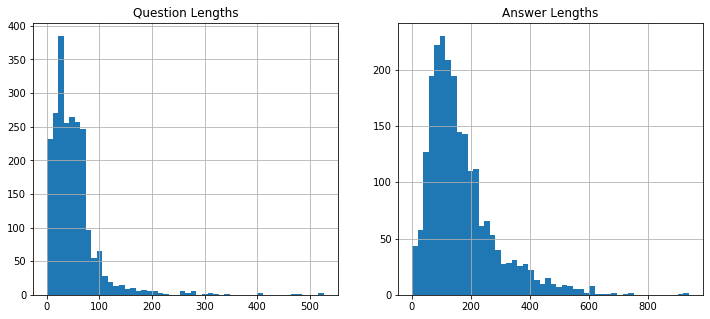

In [9]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.hist(qu_lens, bins=50); ax1.set_title('Question Lengths'); ax1.grid()
ax2.hist(an_lens, bins=50); ax2.set_title('Answer Lengths'); ax2.grid()
plt.show()

In [10]:
len(df), df.questionTitle.nunique(), df.questionText.nunique(), df.answerText.nunique()

(2271, 890, 827, 2127)

### data structure

- many questions have multiple answers
- most answers are unique, but there are some duplicates

How many answers per question?

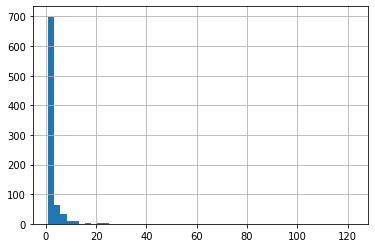

In [11]:
fig, ax = plt.subplots()
_ = ax.hist(df.groupby('questionText').size().values, bins=50)
ax.grid()

### observe some data

In [12]:
def print_sample():
    sample_qid = df.sample(1)['questionID'].iloc[0]
    qu_mask = df.questionID == sample_qid
    df_qu = df[qu_mask]
    print('QUESTION:')
    print(df_qu.iloc[0]['questionText'])
    for idx, row in df_qu.iterrows():
        print('\nANSWER:')
        print(row['answerText'])

In [13]:
print_sample()

QUESTION:
My brother has been diagnosed with paranoid schizophrenia and has not been taking his medication. He's been using methamphetamine and alcohol and was found sleeping naked in my step mom driveway in 12 degree weather.
   I was adopted in by his dad (who just passed) and his mother will not Get involved because she's afraid of financial responsibility.    Do I have the rights to be able to sign my brother into mentalhealth facility?

ANSWER:
I'm sorry to hear that your brother has been having such a rough time. He's lucky to have you on his side (although he may not always see it that way).As far as whether you can sign him in, that depends on a lot of different things.I would suggest that you Google the state and county that you live in as well as some phrase similar to "crisis hotline." They can tell you how it works in that county. My guess is that you could sign him in as long as he met the criteria for admission at that moment, but I can't  be entirely sure. You could also


> It seems like since the "winter blues" happens to you every year it may also be impacting your quality of life and possibly relationships.

### How reliable is the `questionID` field?

In [14]:
df.groupby('questionID')['questionTitle'].nunique().to_frame(
    'num_questionTitles').groupby('num_questionTitles').size()

num_questionTitles
1    864
2     21
dtype: int64

In [15]:
df.groupby('questionID')['questionText'].nunique().to_frame(
    'num_questionTitles').groupby('num_questionTitles').size()

num_questionTitles
1    864
2     21
dtype: int64

Most `questionID`s map to a single `questionText`/`questionTitle`. It isn't perfect, but is reliable enough for now.

# TRAIN/TEST SPLIT

In [16]:
df.split.value_counts(dropna=False)

train    1963
val       185
test      123
Name: split, dtype: int64

# REFLECTION MINING

### first sentence

In [146]:
sent_split_regex = re.compile(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s')

In [147]:
df['first_an_sent'] = df.answerText.apply(lambda x: sent_split_regex.split(x)[0])

In [148]:
df[['answerText', 'first_an_sent']].sample(10)

,answerText,first_an_sent
1398,I think the best thing for you is to speak with someone on how you can best cope with the situation. It can be challenging living in a household with someone who is currently addicted. It is als...,I think the best thing for you is to speak with someone on how you can best cope with the situation.
2217,"It is absolutely normal to be nervous about therapy. Many people take years to make the decision to start counseling and although it is a safe place to explore feelings, it may be the first time ...",It is absolutely normal to be nervous about therapy.
1993,"This is actually more common then we often realize, and actually understandable, as he has gone through a trauma, an unresolved existential crisis. He was taken care of by others and now is again...","This is actually more common then we often realize, and actually understandable, as he has gone through a trauma, an unresolved existential crisis."
1078,"Anger is a normal emotion, no different than joy, elation, or sadness. It's not anger that gets us in trouble it's the overtness of the emotion or how we allow it to manifest that gets us in troub...","Anger is a normal emotion, no different than joy, elation, or sadness."
1423,"There are many conflicting emotions and tasks that arise when one becomes a caretaker for their parent. Expressing positive emotions to her (i.e. ""Mom, I love and care for you, and enjoy our time ...",There are many conflicting emotions and tasks that arise when one becomes a caretaker for their parent.
2020,"Hello, and thank you for your question. Self-diagnosing is something that we all do about one health issue or another. Taking a guess about what may or may not be happening to us is completely nor...","Hello, and thank you for your question."
440,"A break up, even one that you initiated, may deserve some time and space to allow it to be complete.There's a few ideas I'll throw out there and you can choose if they stick. One is to re-invest ...","A break up, even one that you initiated, may deserve some time and space to allow it to be complete.There's a few ideas I'll throw out there and you can choose if they stick."
305,"Hi Boise, I'm sorry that you've lost this love. The fact that you were planning marriage and a future tells me that you meant something very special to each other at that time. It's different now....","Hi Boise, I'm sorry that you've lost this love."
813,I'm glad you're aware of how you honestly feel. Knowing one's personal truth is always the first step in finding what is necessary to be and develop.Reflect a little more on the type of care you'...,I'm glad you're aware of how you honestly feel.
544,"This is a very common question in my practice. Panic attacks typically emerge from an underlying issue (ex. Depression, low self-esteem, fears). To decrease your anxiety symptoms it’s recommended ...",This is a very common question in my practice.


In [149]:
df[['answerText', 'first_an_sent']].sample(10)

,answerText,first_an_sent
77,"Depression and anxiety can be disconcerting and disruptive to our lives in many ways. I am sorry that you are suffering so much. Depression and anxiety can arise due to experiences, genetics or a ...",Depression and anxiety can be disconcerting and disruptive to our lives in many ways.
838,Hi!I’m sorry you’re having this dilemma. I wish I knew a little more about the situation to give a better answer. Have you discussed what is causing you to consider breaking up with your partner? ...,Hi!I’m sorry you’re having this dilemma.
1437,"These are common challenges that involve setting healthy boundaries with family, as well as friends and co-workers. Therapy can help you to define, establish and enforce boundaries between self a...","These are common challenges that involve setting healthy boundaries with family, as well as friends and co-workers."
1211,Pleasing someone certainly does feel satisfying. If the other person does not appreciate your effort and good will then this feels dissatisfying.Offering happiness to someone does not include tol...,Pleasing someone certainly does feel satisfying.
567,How is your boyfriend responding to your discomfort around him?Has he told you that he's noticed changes in you?The good news about a relationship is that you can talk about matters with the other...,How is your boyfriend responding to your discomfort around him?Has he told you that he's noticed changes in you?The good news about a relationship is that you can talk about matters with the other...
2167,It is usually time to end counseling sessions when it is clear to both the client and the counselor that therapeutic goals have been reached and enough improvement has been made that the client ca...,It is usually time to end counseling sessions when it is clear to both the client and the counselor that therapeutic goals have been reached and enough improvement has been made that the client ca...
62,"Not at all! Whatever issues you might have you can bring to the therapy room. Remember therapy is about YOU, not your therapist. You bring whatever you need to bring to the table. Keep in mind the...",Not at all! Whatever issues you might have you can bring to the therapy room.
2191,A counselor can do a few things that can be helpful:1) Give you a space where you can explore what's in your head without worrying about being judged or punished.2) Help you better understand your...,A counselor can do a few things that can be helpful:1) Give you a space where you can explore what's in your head without worrying about being judged or punished.2) Help you better understand your...
1518,"I understand that this can be difficult when you care about someone. Have you had a discussion with your mom as to why she does not want you and this boy to see each other, and what her concerns a...",I understand that this can be difficult when you care about someone.
1386,"While smoking can be incredibly difficult to quit doing, it's not impossible, so the first thing to NOT lose is hope. And certainly planning to have a baby can be exactly the catalyst that one nee...","While smoking can be incredibly difficult to quit doing, it's not impossible, so the first thing to NOT lose is hope."


### "seems like" / "sounds like"

In [158]:
import re
seem_sounds_regex = re.compile(r'^.{0,50}?(?:seems\slike)|(?:sounds\slike)')

In [159]:
def extract_seems_sounds(s):
    sents = sent_split_regex.split(s)
    for sent in sents:
        match = seem_sounds_regex.match(sent.lower())
        if match is not None: return sent

In [160]:
df['seems_sounds_sents'] = df.answerText.apply(extract_seems_sounds)

In [161]:
df.seems_sounds_sents.isnull().value_counts()

True     2232
False      39
Name: seems_sounds_sents, dtype: int64

This method did not yield many new reflections. Only 35 out of 2k+. 

In [24]:
seems_sounds_mask = df.seems_sounds_sents.notnull()
df.loc[seems_sounds_mask, ['answerText', 'seems_sounds_sents']].sample(10)

,answerText,seems_sounds_sents
2243,Great question. The decision to pursue therapy can be a very difficult one and the fact that there seem to be so many profiles that you have to wade through can be particularly daunting. Here's wh...,Set up an appointment with the person who seems like the best fit and give it a try for the first session
868,"It's difficult to move on and let go, especially when you've experienced things for the first time with someone, or feelings you've never felt before, as you said.I like the fact that you are look...","It seems like it's the LOVE that you can't let go of, and the feelings"
267,"It seems like you may be experiencing depression symptoms, they could be the triggered by unexpected life changes, or building up throughout time.The important part is that you have identified the...","It seems like you may be experiencing depression symptoms, they could be the triggered by unexpected life changes, or building up throughout time"
1439,Sounds like it is time to set some boundaries with your mom. You can do this by letting her know that you understand how she is feeling and you understand that she is under a tremendous amount of...,Sounds like it is time to set some boundaries with your mom
209,"Teenage years are rough for anyone, and this is a time for self-discovery and experimentation. Having older parents can certainly pose challenges. Most kids feel like their parents don't understan...","It seems like you're looking for affirmation from them, looking for their approval and understanding"
554,"Sounds like you are struggling with your own negative thoughts. As you stated, everything was great then you started having low self-esteem thoughts and thinking. What is contributing to these n...",Sounds like you are struggling with your own negative thoughts
582,Sounds like your panic is less about loosing the relationship you are in (which by the way doesn't sound like it's meeting YOUR need for connection) and more about being alone. Being with him is s...,Sounds like your panic is less about loosing the relationship you are in (which by the way doesn't sound like it's meeting YOUR need for connection) and more about being alone
227,It seems like you are very receptive of your husband’s emotions and want to support him trough this time. But it is also important of being aware of your emotions. How are you feeling after the ...,It seems like you are very receptive of your husband’s emotions and want to support him trough this time
1704,Sounds like you are dealing with a lot within your self which is causing you great pain. I would suggest that first you get a full physical evaluation to make sure that you are ok physically. Th...,Sounds like you are dealing with a lot within your self which is causing you great pain
480,"Yes, it seems like you may have a type of anxiety: but considering that it is intermittent, it may be a good idea to talk to a therapist and explore what triggers the anxiety. Different types of ...","Yes, it seems like you may have a type of anxiety: but considering that it is intermittent, it may be a good idea to talk to a therapist and explore what triggers the anxiety"


### construct a reflection for each example

Assume that the "seems like"/"sounds like" sentences are higher quality reflections than the first sentences.

In [25]:
df['reflection'] = df.first_an_sent

seems_sounds_mask = df.seems_sounds_sents.notnull()
df.loc[seems_sounds_mask, 'reflection'] = df.loc[seems_sounds_mask, 'seems_sounds_sents']

# MODELING

In [26]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn as nn
import torch.nn.functional as F

In [27]:
def toggle_model_freeze(model, frozen:bool):
    for p in model.parameters(): p.requires_grad = not frozen
        
def print_frozenness(model):
    x = [p.requires_grad for p in model.parameters()]
    n_frozen = len(x)-sum(x)
    n_params = len(x)
    print(f'{n_frozen} / {n_params} ({n_frozen/n_params*100:.3f})% parameters are frozen')

### Pretrained RoBERTA encoder

In [28]:
from transformers import RobertaModel, RobertaTokenizer

In [29]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [30]:
roberta = RobertaModel.from_pretrained('roberta-base')

In [31]:
toggle_model_freeze(roberta, frozen=True)
print_frozenness(roberta)

199 / 199 (100.000)% parameters are frozen


### LSTM decoder

In [32]:
class VarLenLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        
    def forward(self, x, x_lens, h_0, c_0):
        """
        Most of the code here handles the packing and unpacking that's required to efficiently
        perform LSTM calculations for variable length sequences.
        
        Args:
            x: Distributed input tensors, ready for direct input to LSTM
            x_lens: Sequence lengths of examples in the batch
            h_0: Tensor to initialize LSTM hidden state
            c_0: Tensor to initialize LSTM cell state
        """
        max_seq_len = x.size(1)
        sorted_lens, idx = x_lens.sort(dim=0, descending=True)
        x_sorted = x[idx]
        x_packed = pack_padded_sequence(x_sorted, lengths=sorted_lens, batch_first=True)
        out_packed, (h_n, c_n) = self.lstm(x_packed, (h_0, c_0))
        out_padded, _ = pad_packed_sequence(out_packed, batch_first=True, total_length=max_seq_len)
        _, reverse_idx = idx.sort(dim=0, descending=False)
        out_padded = out_padded[reverse_idx]
        h_n = h_n[:, reverse_idx]
        c_n = c_n[:, reverse_idx]
        return out_padded, (h_n, c_n)

### dataset

In [33]:
class ReflectionDataset(Dataset):
    def __init__(self, question_text, reflection, tokenizer, max_seq_len=512):
        self.question_text, self.reflection = question_text, reflection
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        
    def __len__(self): return len(self.question_text)
        
    def __getitem__(self, i):
        input_ids_qu, attn_mask_qu = self.tokenize(
            self.question_text.iloc[i], 
            self.tokenizer,
            self.max_seq_len)
        input_ids_re, attn_mask_re = self.tokenize(
            self.reflection.iloc[i], 
            self.tokenizer,
            self.max_seq_len)
        
        # shift inputs and targets by 1
        target_ids = input_ids_re[1:]
        input_ids_re = input_ids_re[:-1]
        
        return (input_ids_qu, attn_mask_qu, input_ids_re, attn_mask_re), target_ids
        
    @staticmethod
    def tokenize(s, tokenizer, max_seq_len):
        encoded_dict = tokenizer.encode_plus(s, max_length=max_seq_len, pad_to_max_length=True)
        input_ids = torch.tensor(encoded_dict['input_ids'], dtype=torch.long)
        attn_mask = torch.tensor(encoded_dict['attention_mask'], dtype=torch.uint8)
        return input_ids, attn_mask

In [34]:
train_mask = df.split == 'train' 
valid_mask = df.split == 'val'
test_mask = df.split == 'test'
train_mask.sum(), valid_mask.sum(), test_mask.sum()

(1963, 185, 123)

In [35]:
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping

In [36]:
class ReflectionModel(LightningModule):
    def __init__(self, roberta, enc_hidden_sz=768, dec_hidden_sz=256, dec_input_sz=768):
        super().__init__()
        self.enc = roberta
        
        # map encoder output to decoder initialization
        self.h_transform = nn.Linear(enc_hidden_sz, dec_hidden_sz, bias=True)
        self.c_transform = nn.Linear(enc_hidden_sz, dec_hidden_sz, bias=True)
        
        # decoder word embeddings
        emb = roberta.embeddings.word_embeddings.weight.detach().clone()
        self.dec_emb = nn.Embedding.from_pretrained(
            embeddings=emb,
            freeze=False,
            padding_idx=1)
        dec_vocab_sz = emb.shape[0]
        
        # LSTM decoder
        self.dec = VarLenLSTM(
            input_size=dec_input_sz,
            hidden_size=dec_hidden_sz)
        
        # project encoder hidden states as part of decoder-encoder attention
        self.proj_enc = nn.Linear(enc_hidden_sz, dec_hidden_sz, bias=False)
        
        # token-level classification MLP
        self.token_pred_mlp = nn.Sequential(
            nn.Linear(enc_hidden_sz+dec_hidden_sz, 1000),
            nn.ReLU(),
            nn.Linear(1000, dec_vocab_sz))
        
        self.loss = torch.nn.CrossEntropyLoss(
            ignore_index=tokenizer.convert_tokens_to_ids('<pad>'), 
            reduction='mean')
        
    def _encode(self, input_ids, attn_mask):
        
        # forward pass through the encoder
        last_hidden_state, _ = self.enc(input_ids=input_ids, attention_mask=attn_mask)
        
        # aggregate encoder outputs with max pooling
        last_hidden_state = last_hidden_state.masked_fill((attn_mask == 0).unsqueeze(2), -1e18)
        #                                                                  (bs, enc_len, enc_hidden)
        encoder_max_pool = F.adaptive_max_pool1d(last_hidden_state.transpose(1,2), 1).squeeze(2)
        
        # compute decoder initialization
        h = self.h_transform(encoder_max_pool).unsqueeze(0)
        c = self.c_transform(encoder_max_pool).unsqueeze(0)
        
        return last_hidden_state, (h,c)
    
    def _decode(self, last_hidden_state, h, c, input_ids_re, attn_mask_re, attn_mask_qu):
        
        # forward pass through the decoder
        x = self.dec_emb(input_ids_re)
        x_lens = attn_mask_re.sum(1)
        dec_out, (h,c) = self.dec(x, x_lens, h, c)  #(bs, dec_len, dec_hidden)
        
        proj_enc = self.proj_enc(last_hidden_state)  #(bs, enc_len, dec_hidden)
        attn_matrix = torch.bmm(dec_out, proj_enc.transpose(1,2))  #(bs, dec_len, enc_len)
                                                                #rows (dim1) are attn nrgs
        # compute attention over the encoder outputs
        mask = (attn_mask_qu == 0).unsqueeze(1)
        attn_matrix = attn_matrix.masked_fill(mask, -1e18)
        attn_nrgs = F.softmax(attn_matrix, dim=-1)  #(bs, dec_len, enc_len)
        attn_out = torch.bmm(attn_nrgs, last_hidden_state)  #(bs, dec_len, enc_hidden)
        
        # token-level classification (next word prediction)
        mlp_in = torch.cat([dec_out, attn_out], dim=2)  #(bs, dec_len, dec_hidden+enc_hidden)
        logits = self.token_pred_mlp(mlp_in).transpose(1,2)  #(bs, vocab_sz, dec_len)
        
        return logits, (h,c)
        
    def forward(self, input_ids_qu, attn_mask_qu, input_ids_re, attn_mask_re):
        
        # encode
        last_hidden_state, (h,c) = self._encode(input_ids_qu, attn_mask_qu)
        
        # decode
        logits, (h,c) = self._decode(last_hidden_state, h, c, input_ids_re, attn_mask_re,
                                     attn_mask_qu)
        
        return logits
        
    def train_dataloader(self):
#         train_ds = ReflectionDataset(
#             question_text=df[train_mask]['questionText'].iloc[:100],          # DELETE ME
#             reflection=df[train_mask]['reflection'].iloc[:100],               # DELETE ME
#             tokenizer=tokenizer)
        train_ds = ReflectionDataset(
            question_text=df[train_mask]['questionText'],          # DELETE ME
            reflection=df[train_mask]['reflection'],               # DELETE ME
            tokenizer=tokenizer)
        train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
        return train_dl
    
    def val_dataloader(self):
        valid_ds = ReflectionDataset(
            question_text=df[valid_mask]['questionText'],
            reflection=df[valid_mask]['reflection'],
            tokenizer=tokenizer)
        valid_dl = DataLoader(valid_ds, batch_size=8, shuffle=False)
        return valid_dl
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)
        scheduler = None
        return optimizer
    
    def training_step(self, batch, batch_idx):
        self.enc = self.enc.eval()
        x, y = batch
        input_ids_qu, attn_mask_qu, input_ids_re, attn_mask_re = x
        logits = self.forward(input_ids_qu, attn_mask_qu, input_ids_re, attn_mask_re)
        loss = self.loss(logits, y)
        log = {'train_loss': loss}
        return {'loss': loss, 'log': log}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        input_ids_qu, attn_mask_qu, input_ids_re, attn_mask_re = x
        logits = self.forward(input_ids_qu, attn_mask_qu, input_ids_re, attn_mask_re)
        loss = self.loss(logits, y)
        log = {'val_loss_batch': loss}
        return {'val_loss_batch': loss, 'log': log}
    
    def validation_epoch_end(self, outputs):
        if len(outputs)==0: return {'val_loss': 15, 'log': {'val_loss': 15}}
        avg_loss = torch.stack([x['val_loss_batch'] for x in outputs]).mean()
        log = {'val_loss': avg_loss}
        return {'val_loss': avg_loss, 'log': log}

In [37]:
model = ReflectionModel(roberta)

## train

In [38]:
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=3,
    verbose=False,
    mode='min'
)
trainer = Trainer(early_stop_callback=early_stop_callback, gpus=1)

In [39]:
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 24309), started 3:39:42 ago. (Use '!kill 24309' to kill it.)

In [40]:
trainer.fit(model)

1

# dev generation

In [61]:
train_ds = ReflectionDataset(
    question_text=df[train_mask]['questionText'],
    reflection=df[train_mask]['reflection'],
    tokenizer=tokenizer)
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)

valid_ds = ReflectionDataset(
    question_text=df[valid_mask]['questionText'],
    reflection=df[valid_mask]['reflection'],
    tokenizer=tokenizer)
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True)

In [48]:
start_token_id = tokenizer.convert_tokens_to_ids('<s>')
end_token_id = tokenizer.convert_tokens_to_ids('</s>')
start_token_id, end_token_id

def generate_reflection_from_tensors(input_ids_qu, attn_mask_qu, model):
    
    model = model.cpu()
    model = model.eval()
    
    last_hidden_state, (h,c) = model._encode(input_ids_qu, attn_mask_qu)
    
    input_ids = torch.tensor(start_token_id).unsqueeze(0).unsqueeze(0)
    attn_mask = torch.tensor(1).unsqueeze(0).unsqueeze(0)
    
    pred_toks = []
    for i in range(10):
        logits, (h,c) = model._decode(last_hidden_state, h, c, input_ids, attn_mask, attn_mask_qu)
        logits = logits.squeeze(2)
        _, idxs = logits.max(dim=1)
        pred_toks.append(idxs.item())
        input_ids = idxs.unsqueeze(0)
            
    return pred_toks


def observe_reflection(model, tokenizer, input_ids_qu=None, attn_mask_qu=None, 
                       input_ids_re=None, string=None):
    
    if string is not None:
        input_ids_qu, attn_mask_qu = ReflectionDataset.tokenize(string, tokenizer, 512)
        input_ids_qu = input_ids_qu.unsqueeze(0)
        attn_mask_qu = attn_mask_qu.unsqueeze(0)
        pred_toks = generate_reflection_from_tensors(input_ids_qu, attn_mask_qu, model)
    else:
        pred_toks = generate_reflection_from_tensors(input_ids_qu, attn_mask_qu, model)
        
    print('Question:')
    print(tokenizer.decode(input_ids_qu.squeeze(0).tolist()))
    
    if input_ids_re is not None:
        print('\nHuman Generated Reflection:')
        print(tokenizer.decode(input_ids_re.squeeze(0).tolist()))
    
    print('\nMachine Generated Reflection:')
    print(tokenizer.decode(pred_toks))
    

In [63]:
train_dl_iter = iter(train_dl)
valid_dl_iter = iter(valid_dl)

In [64]:
print('\n\nTRAINING SET\n' + '='*40)
for _ in range(5):
    x, y = next(train_dl_iter)
    input_ids_qu, attn_mask_qu, input_ids_re, attn_mask_re = x
    print('\n' + '-'*70 + '\n')
    observe_reflection(model, tokenizer, input_ids_qu=input_ids_qu, attn_mask_qu=attn_mask_qu,
                       input_ids_re=input_ids_re)
    
print('\n\nVALIDATION SET\n' + '='*40)
for _ in range(5):
    x, y = next(valid_dl_iter)
    input_ids_qu, attn_mask_qu, input_ids_re, attn_mask_re = x
    print('\n' + '-'*70 + '\n')
    observe_reflection(model, tokenizer, input_ids_qu=input_ids_qu, attn_mask_qu=attn_mask_qu,
                       input_ids_re=input_ids_re)



TRAINING SET

----------------------------------------------------------------------

Question:
<s> After my fiancé cheated on me because of a miscommunication, I pulled myself away from him.    Now he says all he wants is be with me. I'm pushing him away mentally now because he cheated on me again. I make plans with him that I don't keep. I really do love him still and I care about him. Should I give home one more chance?</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

Question:
<s> How does a counselor decide when to end counseling sessions or to terminate working with a client?</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

Question:
<s> My mother has Alzheimer's and she has become so nasty and mean to everyone and she always asks for unrealistic, silly or meaningless items. I get so frustrated and angry, but then I feel guilty because I know it probably isn’t her fault. How can I cope with feeling like this?</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

Question:
<s> What are some difficulties that a counselor can encounter when dealing with a client?</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

Question:
<s> My therapist is gay so there are no sexual issues here. However, my therapist for six years has made me believe that he cares about me and that we are friends. I have loaned money to him many times, and he always paid me back.
   I had a medical emergency last weekend and I was heavily medicated. I knew that this therapist came into my home and wrote down my credit card information so he could pay back what he owed me, but this therapist dropped me off and never came again. I don't know what to do.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

In [65]:
prompt = """I'm annoyed because this stupid COVID quarantine is isolating me from my friends"""
observe_reflection(model, tokenizer, string=prompt)

Question:
<s> I'm annoyed because this stupid COVID quarantine is isolating me from my friends</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [66]:
prompt = """I'm having trouble sleeping and it's ruining a lot of my days"""
observe_reflection(model, tokenizer, string=prompt)

Question:
<s> I'm having trouble sleeping and it's ruining a lot of my days</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [67]:
prompt = """I'm depressed because I'm a terrible video game player and my friend Adam is sooo much better"""
observe_reflection(model, tokenizer, string=prompt)

Question:
<s> I'm depressed because I'm a terrible video game player and my friend Adam is sooo much better</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

In [68]:
prompt = """My girlfriend left me, but it's actually making me happy"""
observe_reflection(model, tokenizer, string=prompt)

Question:
<s> My girlfriend left me, but it's actually making me happy</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [69]:
prompt = """I really don't like being forced to work over the weekend"""
observe_reflection(model, tokenizer, string=prompt)

Question:
<s> I really don't like being forced to work over the weekend</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [72]:
torch.save(model.state_dict(), 'models/reflections.pt')